## I. Introduction

Ce notebook a pour vocation de vérifier une nouvelle fois les résultats des prédictions faites à l'aide des modèles EfficientNetV2B3 & EfficientNetV2S mais cette fois à l'aide de matrices de confusion et de rapports de classification.  
<br>

Ces 2 modèles ont été utilisés pour les dernières comparaisons de modèle pour la classification 2 classes (saine/malade).  
<br>



## II. Chargement des données et preprocessing

### a. Importation des librairies nécessaires

In [1]:
#Importation des librairies de base nécessaires
import os
import io
import gzip
import random
import argparse
from time import time
from datetime import date
from timeit import default_timer as timer

#Importation des librairies de nécessaire à la gestion des données
import numpy as np
import pandas as pd

#Importation des librairies d'affichage de graphiques
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Importation des librairies tensorflow keras nécessaires
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Sequential, datasets, layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionResNetV2, MobileNetV2, EfficientNetB0
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetB4, EfficientNetV2B3, Xception, InceptionV3
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#Librairies de pre-processing input si existante (enlever le commentaire quand nécessaire)
#from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
#from tensorflow.keras.applications.inception_v3 import preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.keras.applications.xception import preprocess_input

#Librairies additionelles pour la modélisation
from vit_keras import vit
from tensorflow.python.client import device_lib
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

D:\Programs\Anaconda3\envs\My_GPU_TensorFL0W\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### b. Vérification de la configuration tensorflow avec GPU

In [2]:
#Check que la version GPU de TensorFlow est bien activée et que le GPU est trouvé
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Récupération du nom du périphérique GPU
devices = device_lib.list_local_devices()
descriptions = [device.physical_device_desc for device in devices]
for desc in descriptions:
    print(desc)

Num GPUs Available:  1

device: 0, name: NVIDIA GeForce RTX 4090 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


### c. Chargement des données

In [3]:
%store -r df_NPD

In [4]:
df_NPD.head()

,Categorie,Plante,Maladie,Saine,Suffixe,Abrev,AbrevMaladie,Rotation,Luminosite,Symetrie,...,Mode,Profondeur de couleur,Moyenne R,Moyenne G,Moyenne B,Taille du fichier,Set,DirPath,FileName,FilePath
0,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,109.957947,129.504242,119.117355,9606,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
1,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,110.123795,129.669220,119.235626,9960,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
2,Apple__Apple_scab,Apple,Apple_scab,0,new30degfliplr.jpg,FREC,Scab,30,0,LR,...,RGB,8,89.325546,109.759598,95.272110,10299,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,00075aa8-d81a-4184-8541-b692b78d398a___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
3,Apple__Apple_scab,Apple,Apple_scab,0,270deg.jpg,FREC,Scab,270,0,0,...,RGB,8,92.044342,125.152634,115.290207,11986,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,01f3deaa-6143-4b6c-9c22-620a46d8be04___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...
4,Apple__Apple_scab,Apple,Apple_scab,0,90deg.jpg,FREC,Scab,90,0,0,...,RGB,8,129.272934,125.058243,113.740295,20194,valid,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...,0208f4eb-45a4-4399-904e-989ac2c6257c___FREC_Sc...,C:\Users\flore\Jupyter\Recog_Plant_Disease\Dat...


In [5]:
#Récupération des données des set train et valid dans 2 nouveaux dataframes
train_data = df_NPD[df_NPD["Set"] == "train"]
valid_data = df_NPD[df_NPD["Set"] == "valid"]

### d. Vérification et équilibrage des données

#### 1-A. Vérification des données pour l'analyse Saine/Malade

In [6]:
#Décompte des valeurs de la classe "Saine" pour les histogrammes
train_health_counts = train_data["Saine"].value_counts()
valid_health_counts = valid_data["Saine"].value_counts()

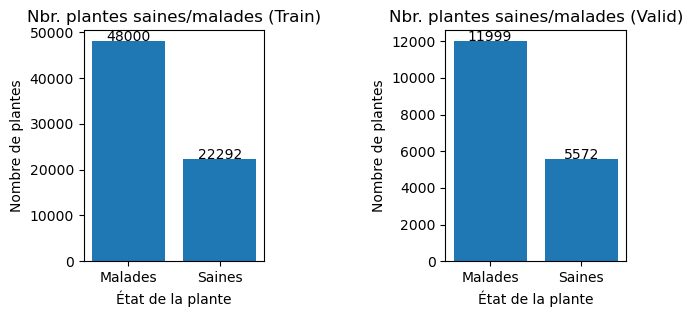

In [7]:
#Initialisation de la taille de la figure
plt.figure(figsize=(7, 3))

#Graphique pour l'ensemble de validation
plt.subplot(1, 2, 1)
plt.bar(["Malades", "Saines"], train_health_counts)
plt.xlabel("État de la plante")
plt.ylabel("Nombre de plantes")
plt.title("Nbr. plantes saines/malades (Train)")
plt.text(0, train_health_counts[0], str(train_health_counts[0]), ha='center')
plt.text(1, train_health_counts[1], str(train_health_counts[1]), ha='center')

#Graphique pour l'ensemble d'entraînement
plt.subplot(1, 2, 2)
plt.bar(["Malades", "Saines"], valid_health_counts)
plt.xlabel("État de la plante")
plt.ylabel("Nombre de plantes")
plt.title("Nbr. plantes saines/malades (Valid)")
plt.text(0, valid_health_counts[0], str(valid_health_counts[0]), ha='center')
plt.text(1, valid_health_counts[1], str(valid_health_counts[1]), ha='center')

#plt.tight_layout()
plt.subplots_adjust(wspace=1)
plt.show()

#### 1-B. Equilibrage des données pour l'analyse "Saine/Malade"

In [8]:
#Sélection des features et de la target
X_train_health = train_data.drop(['Saine'], axis=1)
y_train_health = train_data['Saine']

#Instanciation de RandomOverSampler
oversampler = RandomOverSampler(random_state=111)

#Oversampling uniquement sur les plantes saines
X_train_health_ros, y_train_health_ros = oversampler.fit_resample(X_train_health, y_train_health)

#Création d'un nouveau dataframe avec les données oversampled
train_data_health_ros = pd.concat([X_train_health_ros, y_train_health_ros], axis=1)

#Comptage des données du nouveau dataframe
train_data_health_ros_counts = train_data_health_ros["Saine"].value_counts()

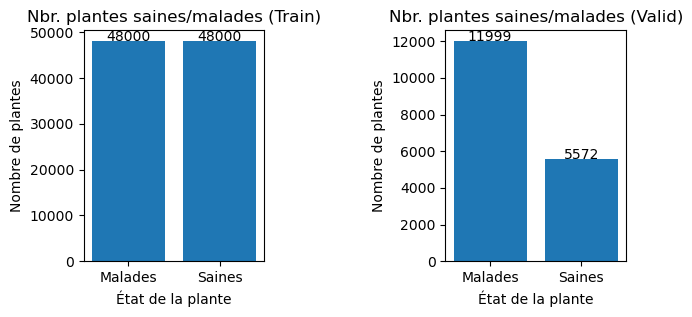

In [9]:
#Initialisation de la taille de la figure
plt.figure(figsize=(7, 3))

#Graphique pour l'ensemble de validation
plt.subplot(1, 2, 1)
plt.bar(["Malades", "Saines"], train_data_health_ros_counts)
plt.xlabel("État de la plante")
plt.ylabel("Nombre de plantes")
plt.title("Nbr. plantes saines/malades (Train)")
plt.text(0, train_data_health_ros_counts[0], str(train_data_health_ros_counts[0]), ha='center')
plt.text(1, train_data_health_ros_counts[1], str(train_data_health_ros_counts[1]), ha='center')

#Graphique pour l'ensemble d'entraînement
plt.subplot(1, 2, 2)
plt.bar(["Malades", "Saines"], valid_health_counts)
plt.xlabel("État de la plante")
plt.ylabel("Nombre de plantes")
plt.title("Nbr. plantes saines/malades (Valid)")
plt.text(0, valid_health_counts[0], str(valid_health_counts[0]), ha='center')
plt.text(1, valid_health_counts[1], str(valid_health_counts[1]), ha='center')

#plt.tight_layout()
plt.subplots_adjust(wspace=1)
plt.show()

In [10]:
#l'Oversampling semble avoir été bien fait sur le set Train.
#   On met le set équilibré dans un nouveau dataframe dans un but d'homogéïnisation des noms
train_data_health = train_data_health_ros

In [11]:
#Déplacement de la colonne "Saine" à la fin dans un nouveau dataframe pour être en adéquation avec
#   le nouveau format du dataframe train_data
valid_data_health = valid_data.loc[:, valid_data.columns != "Saine"].join(valid_data["Saine"])

In [12]:
#Remplacement des 0 et des 1 par une chaîne de caractères (pour une meilleur lisibilité)
train_data_health["Saine"] = train_data_health["Saine"].map({0: "Malade", 1: "Saine"})
valid_data_health["Saine"] = valid_data_health["Saine"].map({0: "Malade", 1: "Saine"})

### e. Pré-processing additionnel sur les données

#### 1. Création d'un ImageDataGenerator pour chacun des 2 sets

In [24]:
#Création du générateur d'image pour Train avec beaucoup de nouvelles modifications bien que les images aient été
#   déjà augmentées. Cela afin d'éviter un sur-apprentissage sur des images trop similaires.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255,
                                   shear_range=0.2, brightness_range=(0.4,1.7),
                                   zoom_range=0.5, rotation_range=40,
                                   width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, vertical_flip=True,
                                   fill_mode='nearest')

#Création du générateur d'image pour Valid avec seulement des modifications cohérentes avec ce qu'on pourrait
#   trouver dans la nature.
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255, 
                                   brightness_range=(0.6,1.2),
                                   zoom_range=0.5, rotation_range=40,
                                   horizontal_flip=True, vertical_flip=True)

#Création d'un set sans modification pour afficher les modifications apportées
norm_datagen = ImageDataGenerator(rescale=1./255)

#### 2. Vérification des modifications appliquées sur les images

__Set Train__

Found 96000 validated image filenames belonging to 2 classes.
Found 96000 validated image filenames belonging to 2 classes.


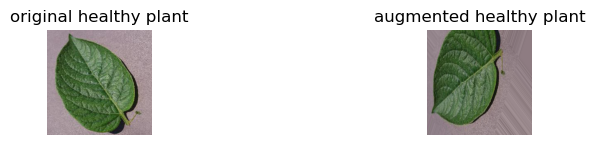

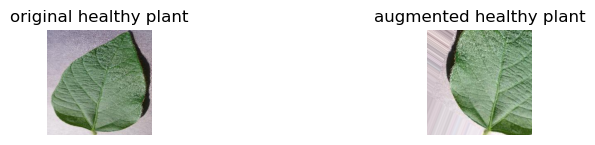

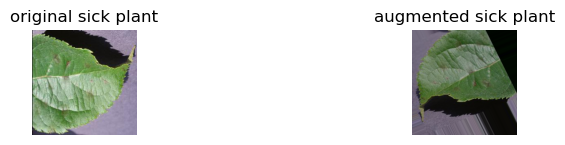

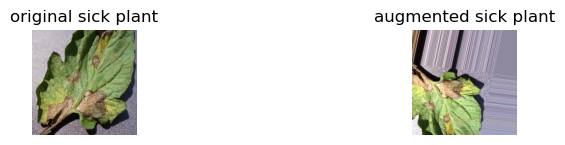

In [25]:
#Affichage de 2x4 images aléatoires
batches_real = norm_datagen.flow_from_dataframe(dataframe=train_data_health, directory=None, x_col='FilePath', y_col='Saine', 
                                                 target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                 seed=111)

batches_augmented = train_datagen.flow_from_dataframe(dataframe=train_data_health, directory=None, x_col='FilePath', y_col='Saine', 
                                                      target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                      seed=111)

x_batch_augmented, y_batch_augmented = next(batches_augmented)
x_batch_real, y_batch_real = next(batches_real)

for i in range(4):
    plt.figure(figsize=(9, 3))
    
    image_augmented = x_batch_augmented[i]
    image_real = x_batch_real[i]
    
    title_add_on = "sick plant"
    if y_batch_augmented[i][1]: title_add_on =  "healthy plant"

    plt.subplot(221)
    plt.imshow(image_real)
    plt.title("original " + title_add_on)
    plt.axis('off')
        
    plt.subplot(222)
    plt.imshow(image_augmented)
    plt.title("augmented " + title_add_on)
    plt.axis('off')

    plt.show()

__Set Valid__

Found 17571 validated image filenames belonging to 2 classes.
Found 17571 validated image filenames belonging to 2 classes.


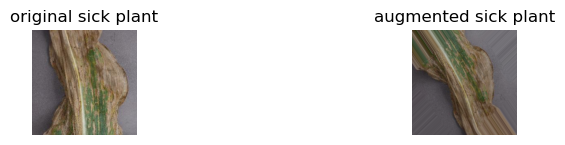

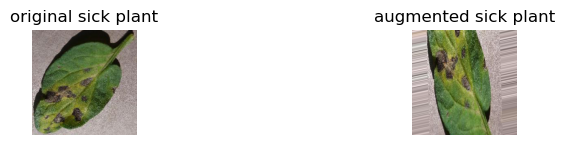

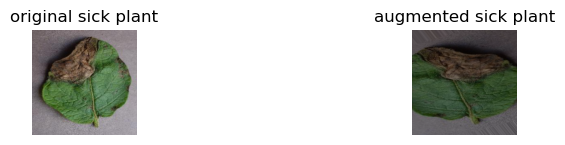

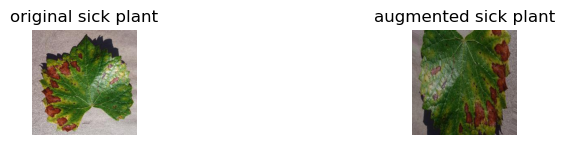

In [26]:
#Affichage de 2x8 images aléatoires
batches_real = norm_datagen.flow_from_dataframe(dataframe=valid_data_health, directory=None, x_col='FilePath', y_col='Saine', 
                                                 target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                 seed=111)

batches_augmented = valid_datagen.flow_from_dataframe(dataframe=valid_data_health, directory=None, x_col='FilePath', y_col='Saine', 
                                                      target_size = (512, 512), batch_size = 4, class_mode = 'categorical', 
                                                      seed=111)

x_batch_augmented, y_batch_augmented = next(batches_augmented)
x_batch_real, y_batch_real = next(batches_real)

for i in range(4):
    plt.figure(figsize=(9, 3))
    
    image_augmented = x_batch_augmented[i]
    image_real = x_batch_real[i]
    
    title_add_on = "sick plant"
    if y_batch_augmented[i][1]: title_add_on =  "healthy plant"

    plt.subplot(221)
    plt.imshow(image_real)
    plt.title("original " + title_add_on)
    plt.axis('off')
        
    plt.subplot(222)
    plt.imshow(image_augmented)
    plt.title("augmented " + title_add_on)
    plt.axis('off')    
    
    plt.show()

### f. Création des datasets

#### 1. Création des Dataset pour l'analyse "Saine/Malade"

In [27]:
print("Création du set d'entraînement avec le générateur d'image :")
training_set_health = train_datagen.flow_from_dataframe(
    dataframe=train_data_health,
    directory=None,   #None car nous utilisons "FilePath" du dataframe pour charger les images
    x_col='FilePath',   #Colonne contenant les chemins des fichiers
    y_col='Saine',   #Colonne contenant les étiquettes
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=111
)

print("\nCréation du set de validation avec le générateur d'image :")
valid_set_health = valid_datagen.flow_from_dataframe(
    dataframe=valid_data_health,
    directory=None,   #None car nous utilisons "FilePath" du dataframe pour charger les images
    x_col='FilePath',   #Colonne contenant les chemins des fichiers
    y_col='Saine',   #Colonne contenant les étiquettes
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=64,
    shuffle=False
)

Création du set d'entraînement avec le générateur d'image :
Found 96000 validated image filenames belonging to 2 classes.

Création du set de validation avec le générateur d'image :
Found 17571 validated image filenames belonging to 2 classes.


## III. Chargement de la sauvegarde des modèles entrainées

### a. Chargement du modèle EfficientNetV2B3

In [30]:
#Répertoire root
cwd = os.getcwd()

#### 1. Chargement du modèle EfficientNetV2B3 pour l'analyse "Saine/Malade"

In [31]:
#Chargement du meilleur modèle sauvegardé lors d'un entraînement précédent
eNetV2B3_health_model_path = cwd + "\\Saved Models\\Best Of\\eNetV2B3_Final-Health_Recog-Full_Model-ENDSAVE.h5"
eNetV2B3_classifier_health = models.load_model(eNetV2B3_health_model_path)

In [32]:
eNetV2B3_classifier_health.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 7, 7, 1536)       12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

### b. Chargement du modèle EfficientNetV2S

#### 1. Chargement du modèle EfficientNetV2S pour l'analyse "Saine/Malade"

In [37]:
#Chargement du meilleur modèle sauvegardé lors d'un entraînement précédent
eNetV2S_health_model_path = cwd + "\\Saved Models\\Best Of\\eNetV2S_Final-Health_Recog-Full_Model-ENDSAVE.h5"
eNetV2S_classifier_health = models.load_model(eNetV2S_health_model_path)

In [38]:
eNetV2S_classifier_health.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

## IV. Evaluation des prédictions avec des images tests

### a. Evaluation des prédictions sur la santé des plantes (Saine/Malade)

#### 1. Evalutation du modèle EfficientNetV2B3

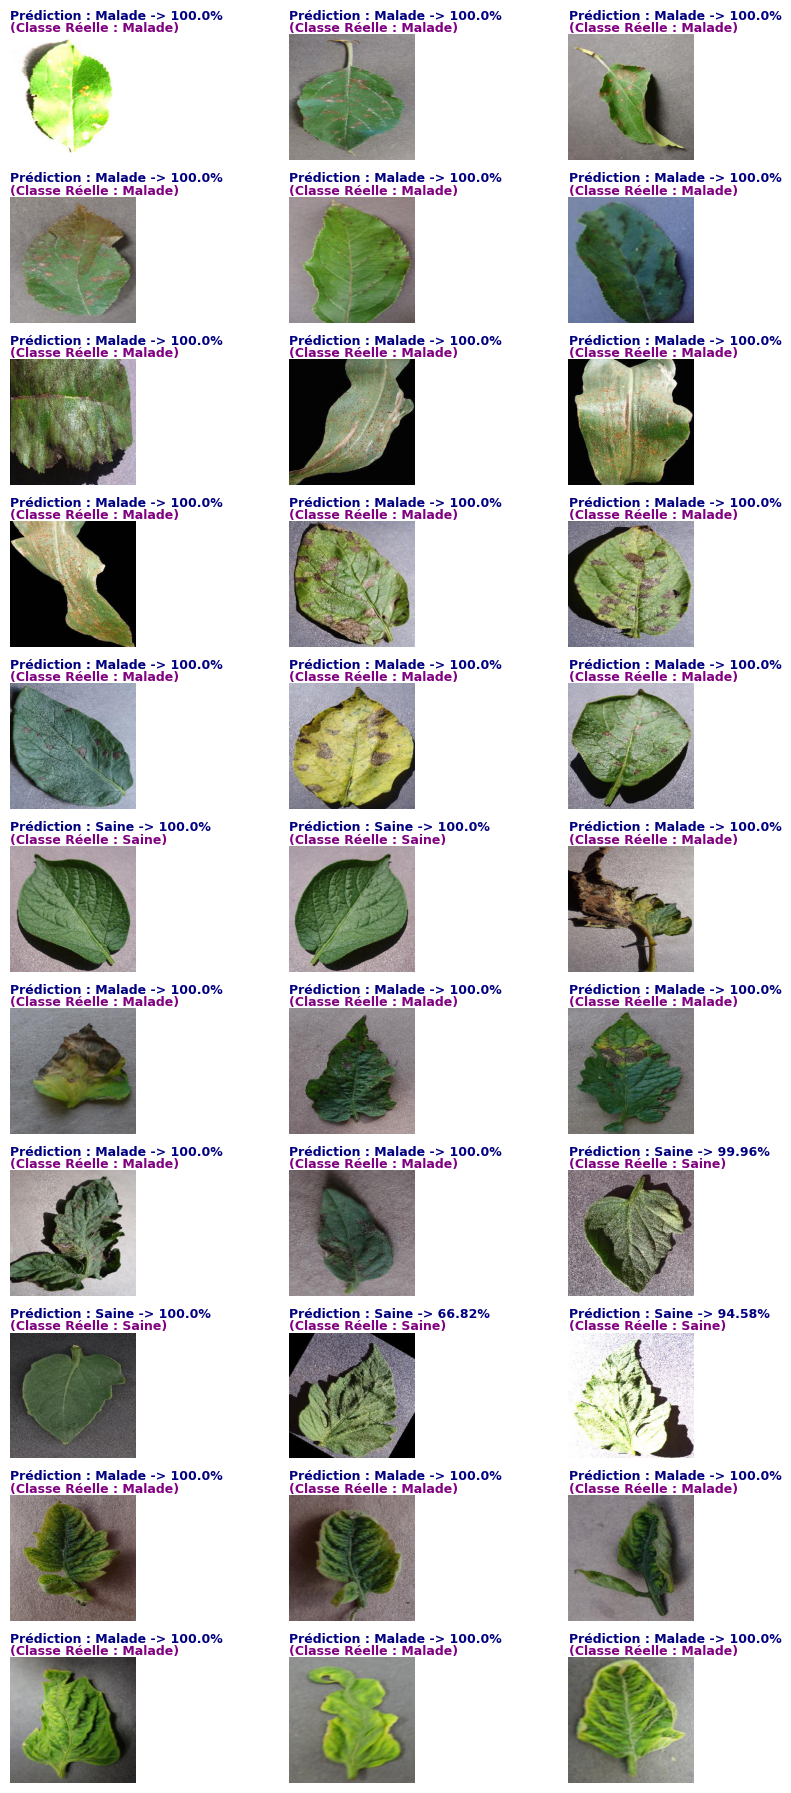

In [43]:
#Chemin du répertoire contenant les images
test_dir = r"C:\Users\flore\Jupyter\Recog_Plant_Disease\Datasets\NPD\test\Test___Pictures_Random"

#Obtention de la liste des noms de fichiers d'images
file_list = os.listdir(test_dir)

# Sélection des 33 fichiers d'images
selected_files = file_list[:33]

#Configuration des sous-plots
fig, axes = plt.subplots(11, 3, figsize=(9, 18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Boucle pour afficher les images
for i, file in enumerate(selected_files):
    file_path = os.path.join(test_dir, file)

    #Récupération de la classe réelle (via le nom du fichier)
    if "Healthy" in file:
        real_class = 'Saine'
    else:
        real_class = 'Malade'

    #Chargement et prétraitement de l'image
    test_image = image.load_img(file_path, target_size=(224, 224))
    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)

    #Prédiction de la classe sans affichage
    proba = round(100 * eNetV2B3_classifier_health.predict(test_image, verbose=0)[0][1], 2)
    if proba < 50:
        plant_state = 'Malade'
        proba = round(100 - proba, 2)
    else:
        plant_state = 'Saine'

    #Chargement et affichage de l'image
    img = mpimg.imread(file_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.text(0, -30, 'Prédiction : ' + plant_state + ' -> ' + str(proba) + '%', color='navy', fontsize=9, fontweight='bold')
    ax.text(0, -5, '(Classe Réelle : ' + real_class + ')', color='purple', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

#### 2. Evalutation du modèle EfficientNetV2S

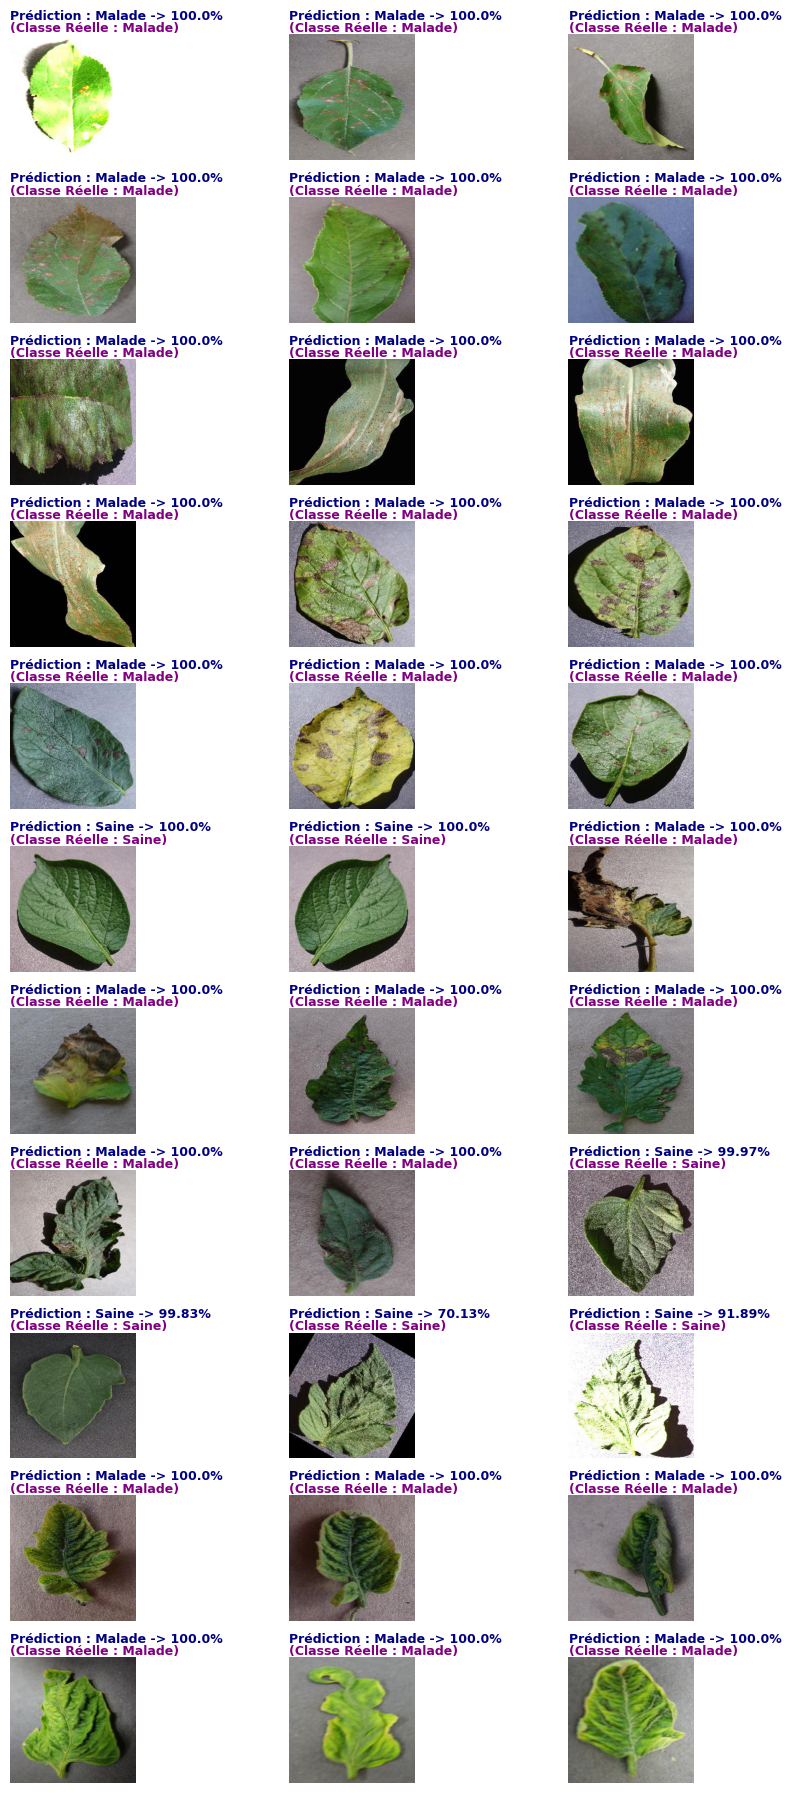

In [44]:
#Chemin du répertoire contenant les images
test_dir = r"C:\Users\flore\Jupyter\Recog_Plant_Disease\Datasets\NPD\test\Test___Pictures_Random"

#Obtention de la liste des noms de fichiers d'images
file_list = os.listdir(test_dir)

# Sélection des 33 fichiers d'images
selected_files = file_list[:33]

#Configuration des sous-plots
fig, axes = plt.subplots(11, 3, figsize=(9, 18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Boucle pour afficher les images
for i, file in enumerate(selected_files):
    file_path = os.path.join(test_dir, file)

    #Récupération de la classe réelle (via le nom du fichier)
    if "Healthy" in file:
        real_class = 'Saine'
    else:
        real_class = 'Malade'

    #Chargement et prétraitement de l'image
    test_image = image.load_img(file_path, target_size=(224, 224))
    test_image = image.img_to_array(test_image) / 255
    test_image = np.expand_dims(test_image, axis=0)

    #Prédiction de la classe sans affichage
    proba = round(100 * eNetV2S_classifier_health.predict(test_image, verbose=0)[0][1], 2)
    if proba < 50:
        plant_state = 'Malade'
        proba = round(100 - proba, 2)
    else:
        plant_state = 'Saine'

    #Chargement et affichage de l'image
    img = mpimg.imread(file_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.text(0, -30, 'Prédiction : ' + plant_state + ' -> ' + str(proba) + '%', color='navy', fontsize=9, fontweight='bold')
    ax.text(0, -5, '(Classe Réelle : ' + real_class + ')', color='purple', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## V. Evaluation des prédictions avec des matrices de confusion

### a. Evaluation des prédictions sur la santé des plantes (Saine/Malade)

In [49]:
#Obtention des vraies classes
health_true_classes = valid_set_health.classes
health_class_labels = list(valid_set_health.class_indices.keys())

#### 1. Evalutation du modèle EfficientNetV2B3

In [50]:
#Obtenir les prédictions du modèle
eNetV2B3_health_predictions = eNetV2B3_classifier_health.predict(valid_set_health)
eNetV2B3_health_predicted_classes = np.argmax(eNetV2B3_health_predictions, axis=1)

275/275 [==============================] - 119s 428ms/step


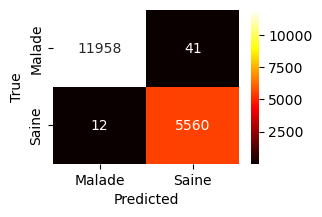

In [51]:
#Création de la matrice de confusion
eNetV2B3_health_confusion_matrix = confusion_matrix(health_true_classes, eNetV2B3_health_predicted_classes) 

#Création d'une heatmap de la matrice de confusion
plt.figure(figsize=(3,2))
sns.heatmap(eNetV2B3_health_confusion_matrix, 
            annot=True, fmt='d', 
            xticklabels=health_class_labels, yticklabels=health_class_labels, 
            cmap='hot')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
#Création du rapport de classification
eNetV2B3_health_report = classification_report(health_true_classes, eNetV2B3_health_predicted_classes, 
                                               target_names=health_class_labels)

print(eNetV2B3_health_report)

              precision    recall  f1-score   support

      Malade       1.00      1.00      1.00     11999
       Saine       0.99      1.00      1.00      5572

    accuracy                           1.00     17571
   macro avg       1.00      1.00      1.00     17571
weighted avg       1.00      1.00      1.00     17571



#### 2. Evalutation du modèle EfficientNetV2S

In [53]:
#Obtenir les prédictions du modèle
eNetV2S_health_predictions = eNetV2S_classifier_health.predict(valid_set_health)
eNetV2S_health_predicted_classes = np.argmax(eNetV2S_health_predictions, axis=1)

275/275 [==============================] - 113s 406ms/step


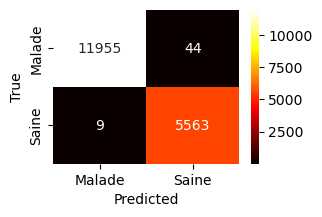

In [54]:
#Création de la matrice de confusion
eNetV2S_health_confusion_matrix = confusion_matrix(health_true_classes, eNetV2S_health_predicted_classes) 

#Création d'une heatmap de la matrice de confusion
plt.figure(figsize=(3,2))
sns.heatmap(eNetV2S_health_confusion_matrix, 
            annot=True, fmt='d', 
            xticklabels=health_class_labels, yticklabels=health_class_labels, 
            cmap='hot')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [55]:
#Création du rapport de classification
eNetV2S_health_report = classification_report(health_true_classes, eNetV2S_health_predicted_classes, 
                                               target_names=health_class_labels)

print(eNetV2S_health_report)

              precision    recall  f1-score   support

      Malade       1.00      1.00      1.00     11999
       Saine       0.99      1.00      1.00      5572

    accuracy                           1.00     17571
   macro avg       1.00      1.00      1.00     17571
weighted avg       1.00      1.00      1.00     17571

